# TASK 1: Single RUL Regressor for DS08  
(organizing the project by task and notebook)
- using the data from dev and test sets for DS08 (the dataset that contains all failures)  
    I first tried this with the first set, the dataset that contains only one failure mode, but it didn't have as many units and I ran into issues with splitting the data up. We should revisit this together tho (anything that I do or say we should always go over again together if there is any doubt)
- build a RUL regressor that predicts the RUL
# UPDATE
- [x] interpolate RUL values
- [x] add cycle information to the training set
- [x] Only train on HS=0
- [x] remove sensor data except for P2 and P50 as in the paper
- [x] put sensor data back in and repeat
- [x] min-max scale to the range -1,1
- [x] update hyperparameters according to discussion
### imports

In [1]:
import os
import pickle
import h5py
import time
import matplotlib
import numpy as np
print(np.__version__)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.stats as stats
import math
import random
import gc
import multiprocessing as mp
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.datasets import mnist, cifar10
import numpy as np
import pandas as pd

print(tf.__version__)
gpu = tf.config.list_physical_devices('GPU')
has_gpu = gpu[0][0].split(':')[1] == 'GPU'
print(f"[INFO] GPU?: <{has_gpu}> {gpu}")
if(has_gpu):
    tf.config.experimental.set_memory_growth(gpu[0], True)

1.19.5
2.1.0
[INFO] GPU?: <True> [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## LOAD the data

In [ ]:
df = pd.read_csv('df08_rul_reg.csv')
df_aux = pd.read_csv('df08_aux_rul_reg.csv')

# drop the first column, alternatively handle it better during saving/loading
df.drop(columns=[df.columns[0]], inplace=True)
df_aux.drop(columns=[df_aux.columns[0]], inplace=True)

## LOAD the labels

In [2]:
y_labels = []
with open("data_csv/y_labels.txt", "r") as f:
    for l in f:
        y_labels.append(l.strip())
        
t_labels = []
with open("data_csv/t_labels.txt", "r") as f:
    for l in f:
        t_labels.append(l.strip())
        
v_labels = []
with open("data_csv/v_labels.txt", "r") as f:
    for l in f:
        v_labels.append(l.strip())
        
print(y_labels)
print(t_labels)
print(v_labels)

['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']
['alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']
['T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi']


## Interpolate y

In [ ]:

units = pd.unique(df.ui)
for u in range(0, len(units)):

    cycles = pd.unique(df[df.ui == u].cycle)
    for c in range(1, len(cycles)):

        y1 = df[(df.ui == u) & (df.cycle == c)].y.values[0]
        y0 = y1 - 1
        n = len(df[(df.ui == u) & (df.cycle == c)])
        yx = np.linspace(y1, y0, n)
        df.loc[((df.ui == u) & (df.cycle == c)), 'y'] = yx

## ~~disregard sensors~~
- keep P2 and P50 as in the paper

In [10]:
df = pd.read_csv('data_csv/df08_all_resampled_interp_h0_fc1.csv')
df.drop(columns=[df.columns[0]], inplace=True)
df.drop(columns=['dataset'], inplace=True)
df.drop(columns=v_labels, inplace=True)
df.head()

,unit,cycle,Fc,hs,ui,y,alt,Mach,TRA,T2,...,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
0,1.0,31.0,1.0,0.0,0,41.000000,3005.0,0.267057,77.694756,515.199325,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
1,1.0,31.0,1.0,0.0,0,40.999070,3053.0,0.269892,77.694756,515.179621,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
2,1.0,31.0,1.0,0.0,0,40.998140,3099.0,0.272097,77.694756,515.134957,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
3,1.0,31.0,1.0,0.0,0,40.997209,3139.0,0.274932,77.694756,515.148320,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
4,1.0,31.0,1.0,0.0,0,40.996279,3178.0,0.277452,77.694756,515.147718,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559


In [13]:
df.columns

Index(['unit', 'cycle', 'Fc', 'hs', 'ui', 'y', 'alt', 'Mach', 'TRA', 'T2',
       'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40',
       'P50', 'Nf', 'Nc', 'Wf', 'T40', 'P30', 'P45', 'W21', 'W22', 'W25',
       'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi',
       'fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod',
       'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod',
       'LPT_eff_mod', 'LPT_flow_mod'],
      dtype='object')

In [14]:
df.drop(columns=v_labels, inplace=True)
df.head()

,unit,cycle,Fc,hs,ui,y,alt,Mach,TRA,T2,...,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
0,1.0,31.0,1.0,0.0,0,41.000000,3005.0,0.267057,77.694756,515.199325,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
1,1.0,31.0,1.0,0.0,0,40.999070,3053.0,0.269892,77.694756,515.179621,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
2,1.0,31.0,1.0,0.0,0,40.998140,3099.0,0.272097,77.694756,515.134957,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
3,1.0,31.0,1.0,0.0,0,40.997209,3139.0,0.274932,77.694756,515.148320,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
4,1.0,31.0,1.0,0.0,0,40.996279,3178.0,0.277452,77.694756,515.147718,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559


In [15]:
df.to_csv('data_csv/df08_set4.csv')

In [18]:
df = pd.read_csv('data_csv/df08_all_resampled_interp_h0_fc1.csv')
df.head()

,Unnamed: 0,unit,cycle,Fc,hs,ui,y,alt,Mach,TRA,...,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
0,0,1.0,31.0,1.0,0.0,0,41.000000,3005.0,0.267057,77.694756,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
1,1,1.0,31.0,1.0,0.0,0,40.999070,3053.0,0.269892,77.694756,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
2,2,1.0,31.0,1.0,0.0,0,40.998140,3099.0,0.272097,77.694756,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
3,3,1.0,31.0,1.0,0.0,0,40.997209,3139.0,0.274932,77.694756,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
4,4,1.0,31.0,1.0,0.0,0,40.996279,3178.0,0.277452,77.694756,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559


In [19]:
df = pd.read_csv('data_csv/df08_set2.csv')
df.head()

,Unnamed: 0,unit,cycle,Fc,hs,ui,y,P2,P50,T40,...,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
0,0,1.0,31.0,1.0,0.0,0,41.000000,13.796511,16.155448,2914.620216,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
1,1,1.0,31.0,1.0,0.0,0,40.999070,13.786445,16.130395,2913.924656,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
2,2,1.0,31.0,1.0,0.0,0,40.998140,13.774472,16.105795,2913.281809,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
3,3,1.0,31.0,1.0,0.0,0,40.997209,13.768953,16.085989,2912.783124,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
4,4,1.0,31.0,1.0,0.0,0,40.996279,13.762214,16.066372,2912.347966,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559


In [21]:
df = pd.read_csv('data_csv/df08_set3.csv')
df.head()

,Unnamed: 0,unit,cycle,Fc,hs,ui,y,P2,P50,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
0,0,1.0,31.0,1.0,0.0,0,41.000000,13.796511,16.155448,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
1,1,1.0,31.0,1.0,0.0,0,40.999070,13.786445,16.130395,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
2,2,1.0,31.0,1.0,0.0,0,40.998140,13.774472,16.105795,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
3,3,1.0,31.0,1.0,0.0,0,40.997209,13.768953,16.085989,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
4,4,1.0,31.0,1.0,0.0,0,40.996279,13.762214,16.066372,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559


In [22]:
df = pd.read_csv('data_csv/df08_set4.csv')
df.head()

,Unnamed: 0,unit,cycle,Fc,hs,ui,y,alt,Mach,TRA,...,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
0,0,1.0,31.0,1.0,0.0,0,41.000000,3005.0,0.267057,77.694756,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
1,1,1.0,31.0,1.0,0.0,0,40.999070,3053.0,0.269892,77.694756,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
2,2,1.0,31.0,1.0,0.0,0,40.998140,3099.0,0.272097,77.694756,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
3,3,1.0,31.0,1.0,0.0,0,40.997209,3139.0,0.274932,77.694756,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
4,4,1.0,31.0,1.0,0.0,0,40.996279,3178.0,0.277452,77.694756,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559


In [ ]:
df.to_csv('df08_set3.csv')

## SAVE the dataframe with ~~removed columns~~ (columns back in) and interpolated y and only hs==0

In [ ]:
df = df[df.hs == 0]
df.head()

In [ ]:
df.to_csv('df08_rul_reg_v2.csv')

## LOAD the v2 dataset

In [ ]:
df = pd.read_csv('df08_rul_reg_v2.csv')
df.drop(columns=[df.columns[0]], inplace=True)
df.head()

### Split the set up by flight class

In [ ]:
df1 = df[df.Fc == 1].reset_index()
df2 = df[df.Fc == 2].reset_index()
df3 = df[df.Fc == 3].reset_index()
print(f"Fc1 units: {pd.unique(df1.ui)}")
print(f"Fc2 units: {pd.unique(df2.ui)}")
print(f"Fc3 units: {pd.unique(df3.ui)}")

In [23]:
df1 = df[df.Fc == 1].reset_index()
df1.head()

,index,Unnamed: 0,unit,cycle,Fc,hs,ui,y,alt,Mach,...,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
0,0,0,1.0,31.0,1.0,0.0,0,41.000000,3005.0,0.267057,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
1,1,1,1.0,31.0,1.0,0.0,0,40.999070,3053.0,0.269892,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
2,2,2,1.0,31.0,1.0,0.0,0,40.998140,3099.0,0.272097,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
3,3,3,1.0,31.0,1.0,0.0,0,40.997209,3139.0,0.274932,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559
4,4,4,1.0,31.0,1.0,0.0,0,40.996279,3178.0,0.277452,...,-0.001481,-0.000917,-0.001461,-0.00157,-0.000486,-0.001469,-0.000947,-0.000781,-0.001757,-0.001559


In [25]:
df_train = pd.read_csv('experiments/best_input_set/set1/train_df.csv')
df_train.head()

In [26]:
train_y = np.load('experiments/best_input_set/set1/train_y.npy')
train_y

array([65.      , 64.998566, 64.99714 , ...,  0.      ,  0.      ,
        0.      ], dtype=float32)

### Split the set up by train, val, test

In [ ]:
def train_test_split(df, y_labels, t_labels, verbose=False):
    ui = list(pd.unique(df.ui))
    samples = len(ui)
    if verbose:
        print(f"unit unique identifier (ui): {ui}")
        print(f"number of units: {samples}")
    
    train_pct = .65
    val_pct = .2
    test_pct = .15
    train_start = 0
    train_cnt = int(samples*train_pct)
    val_cnt = int(samples*val_pct)
    test_cnt = int(samples*test_pct)+1
    if verbose:
        print(f"train, val, test set counts: {train_cnt}, {val_cnt}, {test_cnt}")
    
    assert train_cnt + val_cnt + test_cnt == samples, "error"

    train_ui = random.sample(ui, train_cnt)
    ui = list(set(ui) - set(train_ui))
    val_ui = random.sample(ui, val_cnt)
    ui = list(set(ui) - set(val_ui))
    test_ui = random.sample(ui, test_cnt)
    ui = list(set(ui) - set(test_ui))
    
    assert len(ui) == 0, "error"
    
    if verbose:
        print(f"train ui: {train_ui}")
        print(f"val ui: {val_ui}")
        print(f"test ui: {test_ui}")
    
    train_df = df[df['ui'].isin(train_ui)]
    val_df = df[df['ui'].isin(val_ui)]
    test_df = df[df['ui'].isin(test_ui)]
    
    train_y = np.array(train_df.y, dtype=np.float32)
    val_y = np.array(val_df.y, dtype=np.float32)
    test_y = np.array(test_df.y, dtype=np.float32)
    
    return train_df, train_y, val_df, val_y, test_df, test_y

### Flight class 1 train, val, test sets

In [ ]:
train1_df, train1_y, val1_df, val1_y, test1_df, test1_y = train_test_split(df1, y_labels, t_labels, verbose=True)
train1_pop = pd.concat([train1_df.pop(x) for x in ['index', 'unit', 'Fc', 'hs', 'ui', 'dataset', 'y']], axis=1)
val1_pop = pd.concat([val1_df.pop(x) for x in ['index', 'unit', 'Fc', 'hs', 'ui', 'dataset', 'y']], axis=1)
test1_pop = pd.concat([test1_df.pop(x) for x in ['index', 'unit', 'Fc', 'hs', 'ui', 'dataset', 'y']], axis=1)

In [ ]:
train1_df.head()

### Flight class 2 train, val, test sets

In [ ]:
train2_df, train2_y, val2_df, val2_y, test2_df, test2_y = train_test_split(df2, y_labels, t_labels, verbose=True)
train2_pop = pd.concat([train2_df.pop(x) for x in ['index', 'unit', 'Fc', 'hs', 'ui', 'dataset', 'y']], axis=1)
val2_pop = pd.concat([val2_df.pop(x) for x in ['index', 'unit', 'Fc', 'hs', 'ui', 'dataset', 'y']], axis=1)
test2_pop = pd.concat([test2_df.pop(x) for x in ['index', 'unit', 'Fc', 'hs', 'ui', 'dataset', 'y']], axis=1)


### Flight class 3 train, val, test sets

In [ ]:
train3_df, train3_y, val3_df, val3_y, test3_df, test3_y = train_test_split(df3, y_labels, t_labels, verbose=True)
train3_pop = pd.concat([train3_df.pop(x) for x in ['index', 'unit', 'Fc', 'hs', 'ui', 'dataset', 'y']], axis=1)
val3_pop = pd.concat([val3_df.pop(x) for x in ['index', 'unit', 'Fc', 'hs', 'ui', 'dataset', 'y']], axis=1)
test3_pop = pd.concat([test3_df.pop(x) for x in ['index', 'unit', 'Fc', 'hs', 'ui', 'dataset', 'y']], axis=1)


### Now we have 3 models to train, one for each flight class

One dimensional convolutional neural network architecture (1-d CNN). The architecture of the CNN neural network used in this research also comprises five layers (L = 5). The network has three initial convolutional layers with filters of size 10. The first two convolutions have ten channels and the last convolution has only one channel. Zero padding is used to keep the feature map through the network. The resulting 2D feature map is flattened and the network ends with a 50-way fully connected layer followed by a linear output neuron. The network uses ReLu as the activation function. The network has 24k trainable parameters (H). Similarly as for the FNN, the final architecture is the result of conducting a grid-search over the following hyperparameters: number of hidden layers [1-4], number of channels [10, 20, 30] at each convolutional layer, filter size [10, 20], number of neurons at the fully connected layer [50, 100], activation function type [tanh, relu], and window size of the siding window [20, 50, 200].

mini-batch stochastic gradient discent, batch size = 1024 learning rate .001, 60 epochs for FNN and 30 epochs for CNN, patience of 5 epochs

### STEPS
1. normalize
2. temporalize

### ~~Standardize~~ NORMALIZE the data
- min-max scale with feature range from -1,1

In [ ]:
train1_np = train1_df.to_numpy()
val1_np = val1_df.to_numpy()
test1_np = test1_df.to_numpy()

train2_np = train2_df.to_numpy()
val2_np = val2_df.to_numpy()
test2_np = test2_df.to_numpy()

train3_np = train3_df.to_numpy()
val3_np = val3_df.to_numpy()
test3_np = test3_df.to_numpy()

In [ ]:
scaler1 = MinMaxScaler(feature_range=(-1,1))
scaler1.fit(train1_np)
train1_np = scaler1.transform(train1_np)
val1_np = scaler1.transform(val1_np)
test1_np = scaler1.transform(test1_np)

scaler2 = MinMaxScaler(feature_range=(-1,1))
scaler2.fit(train2_np)
train2_np = scaler2.transform(train2_np)
val2_np = scaler2.transform(val2_np)
test2_np = scaler2.transform(test2_np)

scaler3 = MinMaxScaler(feature_range=(-1,1))
scaler3.fit(train3_np)
train3_np = scaler3.transform(train3_np)
val3_np = scaler3.transform(val3_np)
test3_np = scaler3.transform(test3_np)


In [ ]:
def temporalize_data(inputs, outputs, lookback, horizon, n_features, n_out):
        """
            @brief: reshapes a dataset to account for time

            @params:
                inputs: the 'X' vector (what you are training on)
                outputs: the 'y' vector (what you are predicting)
                lookback: the number of samples in the lookback period (NOTE: not
                            the same as lookback_hours)
                horizon: the number of samples in the horizon period (NOTE: not
                            the same as horizon_hours)
                n_features: the number of features in inputs (X)
                n_out: the number of outputs in outputs (y)

            @returns:
                X_out: a 3d numpy matrix of size [sz, lookback, n_features]
                y: a 3d numpy matrix of size [sz, horizon, n_out]
        """
        X_out = []
        y = []
        ################# the number of samples to generate accounts for the lookback and horizon size
        sz = (len(inputs) - (lookback + horizon) - 1)
        for i in range(0, sz):
            temp = []
            for j in range(0, lookback):
                ################# temp stacks sequential observations and creates a single sample
                temp.append(inputs[[i + j]])
            ################# X_out[0] is now a single sample array with the first [0 - <lookback>] observations
            X_out.append(temp)
            temp = []
            if (len(outputs) > 0):
                ################# the subsequent observations are the values to predict
                for j in range(lookback, lookback + horizon):
                    temp.append(outputs[[i + j]])
                ################# y[0] is now a single sample array with the first [<lookback> - <horizon>] observations
                y.append(temp)
        ################# convert to numpy arrays and reshape for LSTM input
        X_out = np.array(X_out)
        X_out = X_out.reshape(X_out.shape[0], lookback, n_features)
        y = np.array(y)
        y = y.reshape(y.shape[0], horizon, n_out)
        return X_out, y


In [ ]:
# 50 timesteps back (our dataset has been downsampled by a factor of 10, this might need changed)
lookback = 5

# 1 timestep forward
horizon = 1

# df columns
n_features = len(train1_df.columns)

# rul
n_out = 1 

# flight class 1
X_train1, y_train1 = temporalize_data(train1_np, train1_y, lookback, horizon, n_features, n_out)
X_test1, y_test1 = temporalize_data(test1_np, test1_y, lookback, horizon, n_features, n_out)
X_val1, y_val1 = temporalize_data(val1_np, val1_y, lookback, horizon, n_features, n_out)

# flight class 2
X_train2, y_train2 = temporalize_data(train2_np, train2_y, lookback, horizon, n_features, n_out)
X_test2, y_test2 = temporalize_data(test2_np, test2_y, lookback, horizon, n_features, n_out)
X_val2, y_val2 = temporalize_data(val2_np, val2_y, lookback, horizon, n_features, n_out)

# flight class 3
X_train3, y_train3 = temporalize_data(train3_np, train3_y, lookback, horizon, n_features, n_out)
X_test3, y_test3 = temporalize_data(test3_np, test3_y, lookback, horizon, n_features, n_out)
X_val3, y_val3 = temporalize_data(val3_np, val3_y, lookback, horizon, n_features, n_out)

### the shape should now be (num_samples, num_timesteps, num_features) and the range should be -1,1

In [ ]:
X_train1.shape

In [ ]:
y_train1.shape

In [ ]:
X_train1[0][0]

## BUILD and TRAIN the model WITHOUT early stopping callback (see below, Tuesday work)

In [ ]:
# # early stopping parameters
# min_delta = 5
# patience = 20

# # compile parameters
# lr = .001

# # fit parameters
# batch_size = 512
# epochs = 300

# model = Sequential(name='fc1_cnn')
# model.add(InputLayer(input_shape=(lookback, n_features), name='input'))

# # I standardized above because I wasn't sure how exactly this is working, need to read more how to use it
# #model.add(BatchNormalization(name='bn'))
# model.add(Conv1D(filters=10, kernel_size=5, strides=1, padding='same', activation='relu', kernel_initializer='glorot_uniform', name='cl1'))
# model.add(Conv1D(filters=10, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='glorot_uniform', name='cl2'))
# model.add(Conv1D(filters=1, kernel_size=10, strides=1, padding='same', activation='relu', kernel_initializer='glorot_uniform', name='cl3'))
# model.add(Flatten(name='l4'))
# model.add(Dense(units=50, kernel_initializer='glorot_uniform', activation='relu', name='dl1'))
# #model.add(Dropout(rate=.25, name='do1'))
# model.add(Dense(units=1, name='output'))


# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                                mode='min', 
#                                                min_delta=min_delta, 
#                                                patience=patience, 
#                                                verbose=1,
#                                                restore_best_weights=True)

# model.compile(loss='mse',
#               optimizer=keras.optimizers.Adam(lr=lr),
#               metrics=[keras.metrics.RootMeanSquaredError()])

# model.summary()

# history = model.fit(X_train1, y_train1, 
#                     batch_size=batch_size, 
#                     epochs=epochs,
#                     validation_data=(X_val1, y_val1))#,
#                     #callbacks=[early_stopping])


# fig = plt.figure(figsize=(9,6))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title("loss")
# plt.show()

# fig = plt.figure(figsize=(9,6))
# plt.plot(history.history['root_mean_squared_error'])
# plt.plot(history.history['val_root_mean_squared_error'])
# plt.title("rmse")
# plt.show()

## EVALUATE the model

In [ ]:
# model.evaluate(X_test1, y_test1, batch_size=32, verbose=1)

In [ ]:
# y_pred = model.predict(X_test1)

In [ ]:
# fig = plt.figure
# plt.plot(y_test1.reshape(-1,1), label='true')
# plt.plot(y_pred, label='pred')
# plt.title("test results")
# plt.xlabel("sample number")
# plt.ylabel("rul")
# plt.show()

How to map the results back to unit and cycle when this information is lost during training?

In [ ]:
# plt.plot(test1_y)
# plt.show()

In [ ]:
# y_pred.shape

### Tuesday work
- implement custom CNN model with functional api
- remove batch normalization
- remove early stopping callback
- remove kernel regularizer
- update hyper parameters 
- previous model had "jumpy" loss due to small batch size and high batch-to-batch variance - how to address?

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.datasets import mnist, cifar10
import numpy as np
import pandas as pd

print(tf.__version__)
gpu = tf.config.list_physical_devices('GPU')
has_gpu = gpu[0][0].split(':')[1] == 'GPU'
print(f"[INFO] GPU?: <{has_gpu}> {gpu}")
if(has_gpu):
    tf.config.experimental.set_memory_growth(gpu[0], True)


2.5.0
[INFO] GPU?: <True> [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
def make_model():
    inputs = keras.Input(shape=(lookback, n_features), name='in1')
    
    x = layers.Conv1D(filters=n_features*3, kernel_size=5, strides=1, padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(.01))(inputs)
    #x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    
    x = layers.Conv1D(filters=n_features*2, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(.01))(x)
    #x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    
    x = layers.Conv1D(filters=1, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(.01))(x)
    #x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
    
    x = layers.Dropout(rate=.25)(x)
    
    x = layers.Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
    
    x = layers.Dropout(rate=.25)(x)
    
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

model = make_model()
model.summary()

# flight class 1

In [ ]:
# early stopping parameters
#min_delta = 8
min_delta = 24
patience = 32

# compile parameters
#lr = .00005
lr = .001

# fit parameters
batch_size = 512
epochs = 300


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               mode='min', 
                                               min_delta=min_delta, 
                                               patience=patience, 
                                               verbose=1,
                                               restore_best_weights=True)

model = make_model()

model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=[keras.metrics.RootMeanSquaredError()])

model.summary()

history = model.fit(X_train1, y_train1, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_val1, y_val1))#,
                    #callbacks=[early_stopping])


fig = plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.show()

fig = plt.figure(figsize=(9,6))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("rmse")
plt.show()

model.evaluate(X_test1, y_test1, batch_size=32, verbose=1)

y_pred = model.predict(X_test1)

fig = plt.figure
plt.plot(y_test1.reshape(-1,1), label='true')
plt.plot(y_pred, label='pred')
plt.title("test results")
plt.xlabel("sample number")
plt.ylabel("rul")
plt.legend()
plt.show()

# Flight class 2

In [ ]:
del model
import gc
gc.collect()

In [ ]:
# early stopping parameters
min_delta = 8
#min_delta = 
patience = 24

# compile parameters
#lr = .00005
lr = .001

# fit parameters
batch_size = 512
epochs = 300


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               mode='min', 
                                               min_delta=min_delta, 
                                               patience=patience, 
                                               verbose=1,
                                               restore_best_weights=True)

model = make_model()

model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=[keras.metrics.RootMeanSquaredError()])

model.summary()

history = model.fit(X_train2, y_train2, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_val2, y_val2))#,
                    #callbacks=[early_stopping])


fig = plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.show()

fig = plt.figure(figsize=(9,6))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("rmse")
plt.show()

model.evaluate(X_test2, y_test2, batch_size=32, verbose=1)

y_pred = model.predict(X_test2)

fig = plt.figure(figsize=(12,6))
plt.plot(y_test2.reshape(-1,1), label='true')
plt.plot(y_pred, label='pred')
plt.title("test results for flight class 2")
plt.xlabel("sample number")
plt.ylabel("rul")
plt.legend()
plt.show()

# Flight Class 3

In [ ]:
del model
import gc
gc.collect()

In [ ]:
# early stopping parameters
min_delta = 8
#min_delta = 
patience = 24

# compile parameters
#lr = .00005
lr = .001

# fit parameters
batch_size = 512
epochs = 300


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               mode='min', 
                                               min_delta=min_delta, 
                                               patience=patience, 
                                               verbose=1,
                                               restore_best_weights=True)
model = make_model()

model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=[keras.metrics.RootMeanSquaredError()])

model.summary()

history = model.fit(X_train3, y_train3, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_val3, y_val3))#,
                    #callbacks=[early_stopping])


fig = plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.show()

fig = plt.figure(figsize=(9,6))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("rmse")
plt.show()

model.evaluate(X_test3, y_test3, batch_size=32, verbose=1)

y_pred = model.predict(X_test3)

fig = plt.figure(figsize=(12,9))
plt.plot(y_test3.reshape(-1,1), label='true')
plt.plot(y_pred, label='pred')
plt.title("test results for flight class 3")
plt.xlabel("sample number")
plt.ylabel("rul")
plt.legend()
plt.show()

## Thoughts
- 

# Tuesday
- ~~bilstm with residual connections using subclassing~~
- reimplement data preprocessing steps and model training in accordance with our discussion


# Wednesday
- custom loss and training functions, bilstm

In [33]:
def test_fcn(b = 9, c = 'hi'):
    fig = plt.figure(figsize=(12,9))
    plt.plot([1,2,3,4,5])
    fig.savefig('testfig.png')
    x = 1
    y = ['a', 3]
    df = pd.DataFrame()
    z = 2 + b
    variables = locals()
    varstr = repr(locals())
    with open('locals1.txt', "w") as f:
        f.write(varstr)

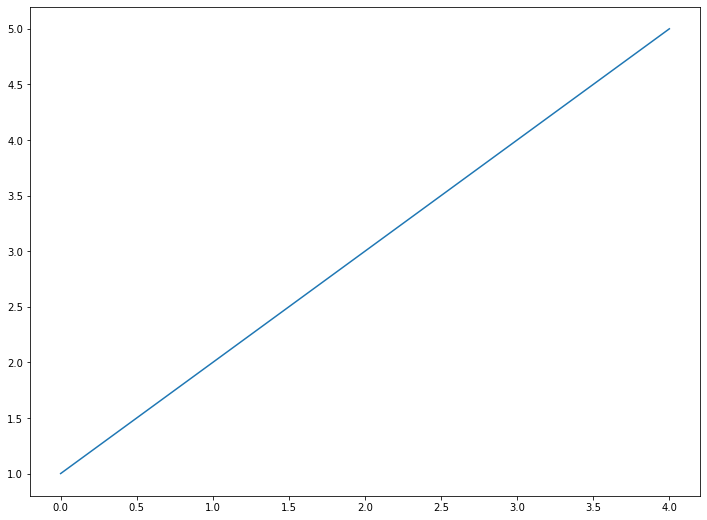

In [34]:
test_fcn()

In [37]:
os.getcwd()

'C:\\Users\\lab\\phm2021_data_challenge'

ERROR! Session/line number was not unique in database. History logging moved to new session 52


In [ ]:
test_df = pd.read_csv('/experiments/best_input_set/set4/test_pop.csv')
pd.unique(test_df.ui)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\lab\envs\tf2gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_6388/2451480659.py", line 1, in <module>
    test_df = pd.read_csv('/experiments/best_input_set/set4/test_pop.csv')
  File "C:\Users\lab\envs\tf2gpu\lib\site-packages\pandas\util\_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\lab\envs\tf2gpu\lib\site-packages\pandas\io\parsers\readers.py", line 586, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "C:\Users\lab\envs\tf2gpu\lib\site-packages\pandas\io\parsers\readers.py", line 482, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "C:\Users\lab\envs\tf2gpu\lib\site-packages\pandas\io\parsers\readers.py", line 811, in __init__
    self._engine = self._make_engine(self.engine)
  File "C:\Users\lab\envs\tf2gpu\lib\si

In [48]:
directories = [
'experiments/best_input_set/set1/',
'experiments/best_input_set/set2/',
'experiments/best_input_set/set3/',
'experiments/best_input_set/set4/'
]


##### for loop block here
i = 3
        ######## load data, concat all to X_train and y_train only, then train
X_train = np.load(directories[i] + 'X_train.npy')
X_val = np.load(directories[i] + 'X_val.npy')
X_test = np.load(directories[i] + 'X_test.npy')

y_train = np.load(directories[i] + 'y_train.npy')
y_val = np.load(directories[i] + 'y_val.npy')
y_test = np.load(directories[i] + 'y_test.npy')

#X_train = np.concatenate([X_train, X_val, X_test], axis=0)
#y_train = np.concatenate([y_train, y_val, y_test], axis=0)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

ERROR! Session/line number was not unique in database. History logging moved to new session 54
(135053, 10, 29)
(135053, 1, 1)
(40700, 10, 29)
(40700, 1, 1)
(38611, 10, 29)
(38611, 1, 1)


In [47]:
X_train.shape[2]

43

In [48]:
y_train.shape[2]

In [6]:
X_train.shape[0]/512

263.775390625

In [40]:
res = np.concatenate([X_train, X_val], axis=0)
res.shape

(175753, 10, 43)

In [58]:
names = [
'set1_xs_xv_w_0',
'set2_2_xv_w_0',
'set3_2_w_0',
'set4_xs_w_0'
]

directories = [
'experiments/best_input_set/set1/',
'experiments/best_input_set/set2/',
'experiments/best_input_set/set3/',
'experiments/best_input_set/set4/'
]


# 50 timesteps back (our dataset has been downsampled by a factor of 5, the downsampling rate is also a hyper parameter to be explored)
lookback = 10


##### for loop block here
for i in range(0, 1):
    
    X_train = np.load(directories[i] + 'X_train.npy')
    X_val = np.load(directories[i] + 'X_val.npy')
    X_test = np.load(directories[i] + 'X_test.npy')

    y_train = np.load(directories[i] + 'y_train.npy')
    y_val = np.load(directories[i] + 'y_val.npy')
    y_test = np.load(directories[i] + 'y_test.npy')

    X_train = np.concatenate([X_train, X_val, X_test], axis=0)
    y_train = np.concatenate([y_train, y_val, y_test], axis=0)

In [49]:
X_train.shape

(135053, 10, 29)

In [50]:
lookback = X_train.shape[1]
n_features = X_train.shape[2]
n_out = 1
lr = .0005
batch_size = 64
epochs = 1000

In [119]:
inputs = keras.Input(shape=(lookback, n_features), name='in1')
x = layers.Dense(units=64, kernel_regularizer=regularizers.l2(.01))(inputs)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.Dropout(rate=.4)(x)

x = layers.Dense(units=64, kernel_regularizer=regularizers.l2(.01))(x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.Dropout(rate=.4)(x)

x = layers.Dense(units=32, kernel_regularizer=regularizers.l2(.01))(x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.Dropout(rate=.4)(x)

outputs = layers.Dense(n_out)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [30]:
def lstm1(lookback, n_features, n_out):
    inputs = keras.Input(shape=(lookback, n_features), name='in1')
    x = layers.LSTM(units=64, return_sequences=True, dropout=.25, recurrent_dropout=.25)(inputs)
    x = layers.LSTM(units=64, return_sequences=False, dropout=.25, recurrent_dropout=.25)(x)
    x = layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
    x = layers.Dropout(rate=.25)(x)
    outputs = layers.Dense(units=n_out)(x)
    model = keras.Model(inputs=x, outputs=outputs)
    return model

In [51]:
def lstm2(lookback, n_features, n_out):
    inputs = keras.Input(shape=(lookback, n_features), name='in1')
    x = layers.LSTM(units=32, return_sequences=True, recurrent_dropout=.25, kernel_regularizer=regularizers.l2(.01))(inputs)
    x = layers.Dropout(rate=.25)(x)
    x = layers.LSTM(units=32, return_sequences=False, recurrent_dropout=.25, kernel_regularizer=regularizers.l2(.01))(x)
    x = layers.Dropout(rate=.25)(x)
    x = layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
    x = layers.Dropout(rate=.25)(x)
    outputs = layers.Dense(units=n_out)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [52]:
model = lstm2(lookback, n_features, n_out)

In [53]:
model.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(learning_rate=lr),
                  metrics=[keras.metrics.RootMeanSquaredError()])

In [54]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in1 (InputLayer)             [(None, 10, 29)]          0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 10, 32)            7936      
_________________________________________________________________
dropout_23 (Dropout)         (None, 10, 32)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0  

In [41]:
type(history.history)

dict

Train on 135053 samples, validate on 40700 samples
Epoch 1/1000
135053/135053 [==============================] - 45s 336us/sample - loss: 95.0070 - root_mean_squared_error: 9.6614 - val_loss: 78.9997 - val_root_mean_squared_error: 8.7930
Epoch 2/1000
135053/135053 [==============================] - 43s 316us/sample - loss: 32.1179 - root_mean_squared_error: 5.5196 - val_loss: 92.1189 - val_root_mean_squared_error: 9.5140
Epoch 3/1000
135053/135053 [==============================] - 43s 316us/sample - loss: 24.0888 - root_mean_squared_error: 4.7484 - val_loss: 113.9199 - val_root_mean_squared_error: 10.6042
Epoch 4/1000
135053/135053 [==============================] - 42s 309us/sample - loss: 19.9581 - root_mean_squared_error: 4.3083 - val_loss: 96.0782 - val_root_mean_squared_error: 9.7341
Epoch 5/1000
135053/135053 [==============================] - 41s 307us/sample - loss: 17.3329 - root_mean_squared_error: 4.0083 - val_loss: 136.6880 - val_root_mean_squared_error: 11.6392
Epoch 6/10

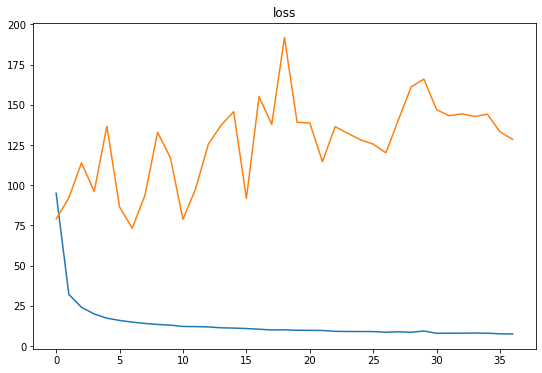

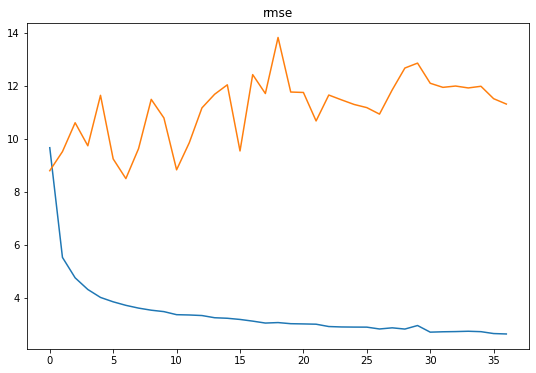

38611/38611 [==============================] - 3s 77us/sample - loss: 223.4283 - root_mean_squared_error: 14.9113


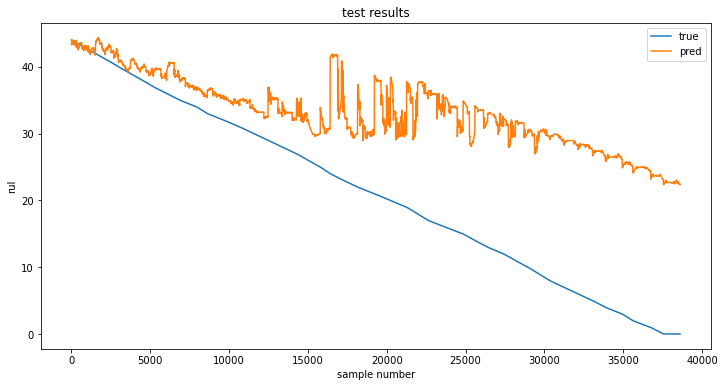

In [55]:
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                    mode='min',
#                                                    min_delta=.1,
#                                                    patience=40,
#                                                    verbose=1,
#                                                    restore_best_weights=True)

# history = model.fit(X_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     callbacks=[early_stopping])


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   mode='min',
                                                   min_delta=.1,
                                                   patience=30,
                                                   verbose=1,
                                                   restore_best_weights=True)

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

fig = plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.show()

fig = plt.figure(figsize=(9,6))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("rmse")
plt.show()

model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

y_pred = model.predict(X_test)

fig = plt.figure(figsize=(12,6))
plt.plot(y_test.reshape(-1,1), label='true')
plt.plot(y_pred, label='pred')
plt.title("test results")
plt.xlabel("sample number")
plt.ylabel("rul")
plt.legend()
plt.show()

In [ ]:
history.history

In [ ]:
fig = plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.show()

fig = plt.figure(figsize=(9,6))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("rmse")
plt.show()

Train on 214364 samples
Epoch 1/1000
214364/214364 [==============================] - 63s 293us/sample - loss: 117.5771 - root_mean_squared_error: 10.8090
Epoch 2/1000
214364/214364 [==============================] - 60s 282us/sample - loss: 28.3038 - root_mean_squared_error: 5.2507
Epoch 3/1000
214364/214364 [==============================] - 60s 281us/sample - loss: 21.5845 - root_mean_squared_error: 4.5760
Epoch 4/1000
214364/214364 [==============================] - 60s 282us/sample - loss: 18.4075 - root_mean_squared_error: 4.2217
Epoch 5/1000
214364/214364 [==============================] - 60s 280us/sample - loss: 16.5992 - root_mean_squared_error: 4.0062
Epoch 6/1000
214364/214364 [==============================] - 60s 280us/sample - loss: 15.4439 - root_mean_squared_error: 3.8639
Epoch 7/1000
214364/214364 [==============================] - 60s 282us/sample - loss: 14.5894 - root_mean_squared_error: 3.7563
Epoch 8/1000
214364/214364 [==============================] - 60s 281us

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Epoch 00194: early stopping
Traceback (most recent call last):
  File "C:\Users\lab\envs\tf2gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_6388/87784377.py", line 29, in <module>
    plt.plot(history.history['val_loss'])
KeyError: 'val_loss'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\lab\envs\tf2gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\lab\envs\tf2gpu\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  F

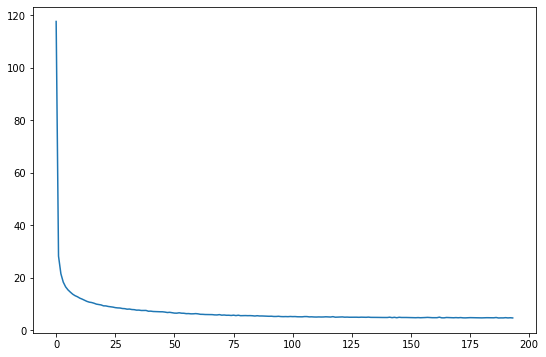

# started at 8:39

In [35]:
model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

y_pred = model.predict(X_test)

ERROR! Session/line number was not unique in database. History logging moved to new session 49
38611/38611 [==============================] - 4s 93us/sample - loss: 0.1661 - root_mean_squared_error: 0.3084


In [82]:
y_pred.reshape(-1, 1).shape

(386110, 1)

In [110]:
y_pred[:,,0]

array([42.691086, 42.70194 , 42.729607, ...,  4.687975,  4.687975,
        4.687975], dtype=float32)

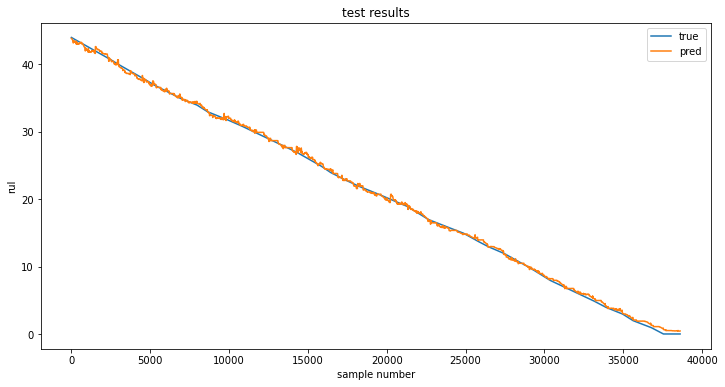

In [36]:
fig = plt.figure(figsize=(12,6))
plt.plot(y_test.reshape(-1,1), label='true')
plt.plot(y_pred, label='pred')
plt.title("test results")
plt.xlabel("sample number")
plt.ylabel("rul")
plt.legend()
plt.show()
                    